현재 상태:

Tumor 디렉토리:

    - SRR30510137: ✅ 완료

    - SRR30510151: ✅ 완료

    - SRR30510181: ✅ 완료

Normal 디렉토리:

    - SRR28602760: ✅ 완료

    - SRR28602761: ✅ 완료

    - SRR28602767: ✅ 완료

각 디렉토리 별로 아래 단계가 완료된 상태입니다.

- fastqc (품질 체크)

- trim_galore (트리밍)

- STAR (정렬 및 BAM 파일 생성)

- featureCounts (유전자 발현량 정량화, counts.txt 생성)

In [ ]:
import pandas as pd
import glob
import os

tumor_paths = glob.glob('./Tumor/*/counts.txt')
normal_paths = glob.glob('./Normal/*/counts.txt')

usecols = ['Geneid', 'SRR']

counts_tumor = []
for path in tumor_paths:
    sample_name = os.path.basename(os.path.dirname(path))
    df = pd.read_csv(path, sep='\t', comment='#', usecols=[0, 6], names=['Geneid', sample_name], header=0)
    counts_tumor.append(df.set_index('Geneid'))

counts_tumor_df = pd.concat(counts_tumor, axis=1)

counts_normal = []
for path in normal_paths:
    sample_name = os.path.basename(os.path.dirname(path))
    df = pd.read_csv(path, sep='\t', comment='#', usecols=[0, 6], names=['Geneid', sample_name], header=0)
    counts_normal.append(df.set_index('Geneid'))

counts_normal_df = pd.concat(counts_normal, axis=1)

combined_counts_df = pd.concat([counts_tumor_df, counts_normal_df], axis=1)
combined_counts_df.columns.name = 'Sample'

print(combined_counts_df.head())

Sample           SRR30510137  SRR30510151  SRR30510181  SRR28602760  \
Geneid                                                                
ENSG00000279928            6            0            2            2   
ENSG00000228037            0            0            7           15   
ENSG00000142611         2403          735          168         1128   
ENSG00000284616            0            0            0            0   
ENSG00000157911         1369          537          889          805   

Sample           SRR28602761  SRR28602767  
Geneid                                     
ENSG00000279928            2            6  
ENSG00000228037            8            6  
ENSG00000142611         1247          504  
ENSG00000284616            0            0  
ENSG00000157911         1177         1301  


In [2]:
combined_counts_df.columns = [
    'Tumor_SRR30510137',
    'Tumor_SRR30510151',
    'Tumor_SRR30510181',
    'Normal_SRR28602760',
    'Normal_SRR28602761',
    'Normal_SRR28602767'
]

In [ ]:
combined_counts_df.to_csv("combined_counts_df.csv", index=False)

In [11]:
combined_counts_df.head()

,Tumor_SRR30510137,Tumor_SRR30510151,Tumor_SRR30510181,Normal_SRR28602760,Normal_SRR28602761,Normal_SRR28602767
Geneid,,,,,,
ENSG00000279928,6,0,2,2,2,6
ENSG00000228037,0,0,7,15,8,6
ENSG00000142611,2403,735,168,1128,1247,504
ENSG00000284616,0,0,0,0,0,0
ENSG00000157911,1369,537,889,805,1177,1301


### 정규화(Normalization)

- RNA-Seq 데이터 분석의 필수 단계입니다. 
- 다양한 방법 중 CPM(Counts Per Million)과 log 변환을 추천합니다.

In [1]:
import numpy as np
import pandas as pd

combined_counts_df = pd.read_csv('combined_counts_df.csv')

def cpm(counts):
    return (counts / counts.sum()) * 1e6

normalized_df = combined_counts_df.apply(cpm, axis=0)
normalized_log_df = np.log2(normalized_df + 1)

normalized_log_df.to_csv('normalized_counts.csv', index=False)

print(normalized_log_df.head())

   Tumor_SRR30510137  Tumor_SRR30510151  Tumor_SRR30510181  \
0           0.114254           0.000000           0.083805   
1           0.000000           0.000000           0.274213   
2           5.087772           3.979975           2.590725   
3           0.000000           0.000000           0.000000   
4           4.307749           3.560476           4.785833   

   Normal_SRR28602760  Normal_SRR28602761  Normal_SRR28602767  
0            0.038284            0.031208            0.109349  
1            0.265062            0.120976            0.109349  
2            4.014973            3.871297            2.928702  
3            0.000000            0.000000            0.000000  
4            3.563635            3.793801            4.175820  


### PCA(Principal Component Analysis)

정규화 후 PCA를 통해 샘플 간 유사성을 탐색하고, 각 군(Tumor vs Normal)의 명확한 분리를 확인할 수 있음

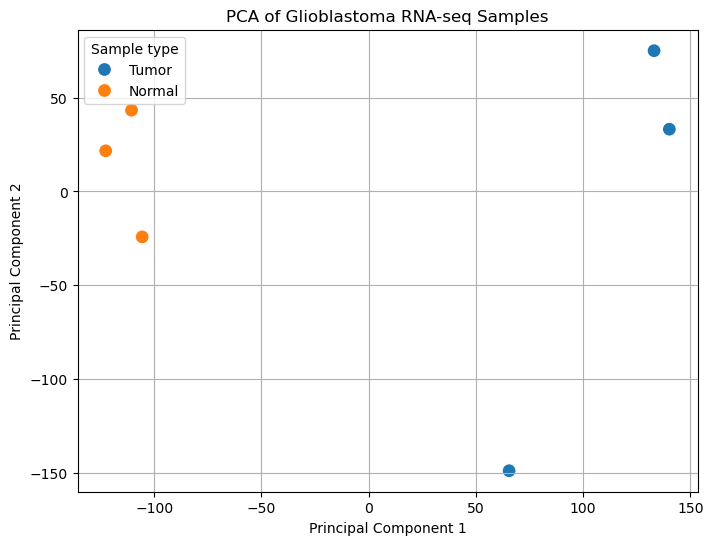

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('normalized_counts.csv')

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data.T)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Sample'] = ['Tumor', 'Tumor', 'Tumor', 'Normal', 'Normal', 'Normal']

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Sample', s=100)

plt.title('PCA of Glioblastoma RNA-seq Samples')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sample type')
plt.grid(True)

plt.savefig('PCA_plot.png')
plt.show()